# Exploring EEG Data from Sleep Deprivation Study

This notebook begins the process of exploring and preparing EEG data from an open-access research study on sleep deprivation. The data come from the OpenNeuro repository, specifically the following dataset:

**Dataset Title:** A Resting-State EEG Dataset for Sleep Deprivation
**Dataset ID:** ds004902
**Link:** https://openneuro.org/datasets/ds004902/versions/1.0.8

The dataset includes resting-state EEG signals from 71 participants recorded under two conditions: once after normal sleep, and once after a night of sleep deprivation. It also includes behavioral measures such as mood and sleepiness. Our goal is to responsibly explore and summarize this dataset in a way that supports public-facing educational features in a future app.

This notebook will:
- Set up the environment and directories
- Load and view EEG data from a small example dataset to confirm our tools work
- Prepare for downloading and working with `ds004902` safely and efficiently


In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import os
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline


The project includes separate folders for raw and cleaned data. This step confirms those folders exist and creates them if they do not. Raw EEG files will be stored in `data/raw/`, and cleaned summary outputs will be saved to `data/clean/`. This organization keeps the workflow modular and easier to maintain.


In [3]:
RAW_DIR = "../data/raw/"
CLEAN_DIR = "../data/clean/"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)

print("Raw directory:", os.path.abspath(RAW_DIR))
print("Clean directory:", os.path.abspath(CLEAN_DIR))


Raw directory: C:\Users\Alexi\projects\eeg-brfss-app\data\raw
Clean directory: C:\Users\Alexi\projects\eeg-brfss-app\data\clean


Before downloading the actual sleep deprivation dataset, it helps to confirm that the system can correctly load and display EEG recordings. This step uses a lightweight example file included with the MNE library. It is not part of the sleep deprivation study, but it follows the same format and structure.

Running this check ensures the environment, libraries, and viewer are working properly. Once confirmed, the real EEG data can be downloaded and explored with confidence.


Opening raw data file C:\Users\Alexi\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Using matplotlib as 2D backend.


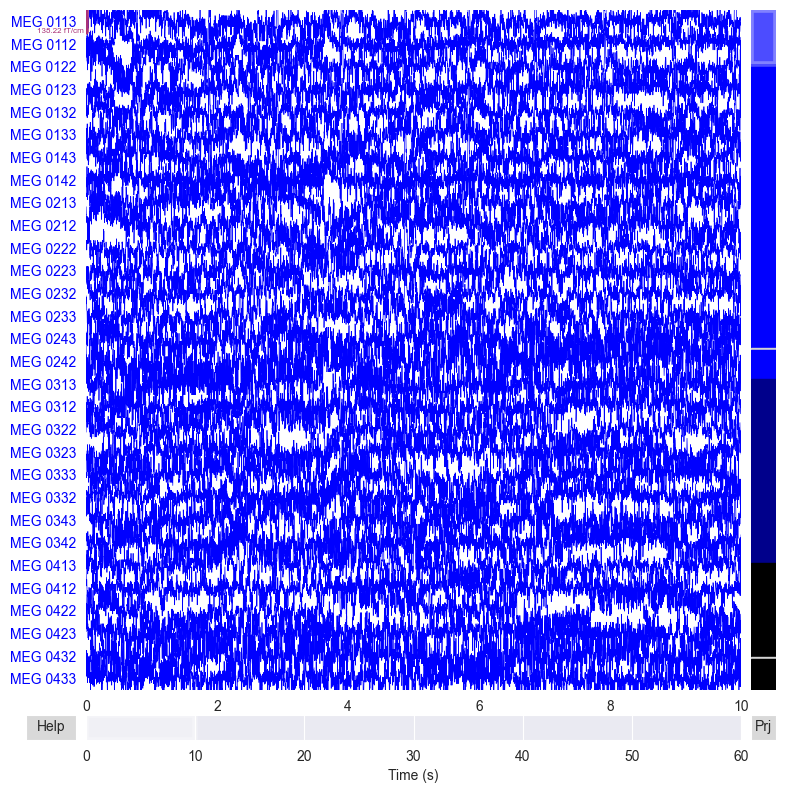

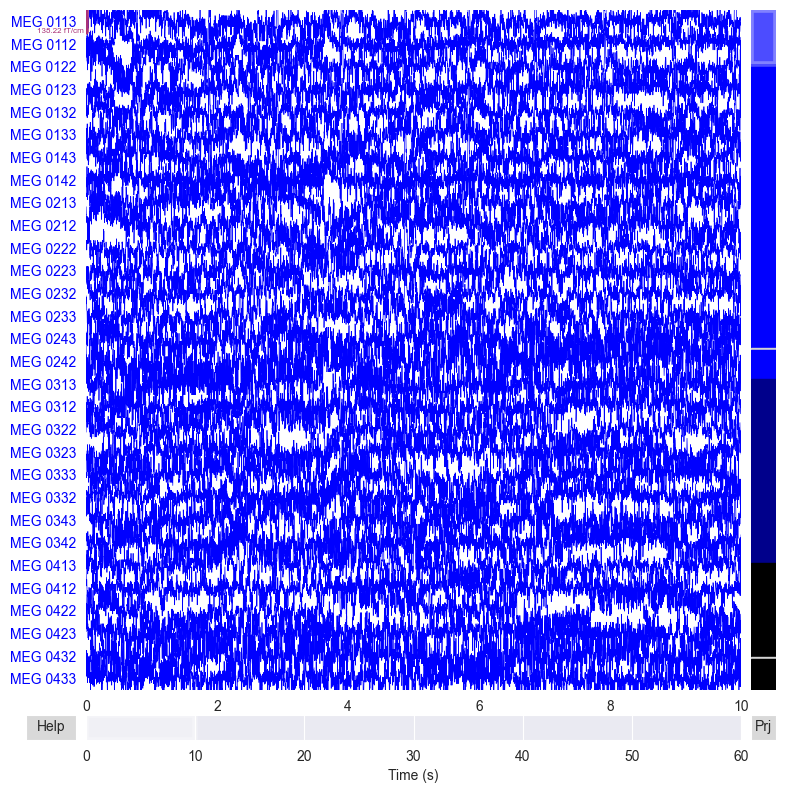

In [4]:
from mne.datasets import sample

# Get the path to MNE's built-in sample EEG data
sample_path = sample.data_path()
raw_path = os.path.join(sample_path, "MEG", "sample", "sample_audvis_raw.fif")

# Load the file and limit it to the first 60 seconds for speed
raw = mne.io.read_raw_fif(raw_path, preload=True)
raw.crop(tmax=60)

# Open a simple viewer to inspect the EEG channels
raw.plot(n_channels=30, scalings="auto", title="Sample EEG Recording (First 60 seconds)")


The image above shows a 60-second segment of EEG and MEG activity from a sample dataset. Each horizontal trace represents a separate sensor channel. The patterns show electrical signals recorded over time and are used to detect activity in the brain. While this sample confirms the tools are working, it does not reflect the structure or content of the sleep deprivation dataset.


The visualization tools have been tested with sample EEG/MEG data. The focus now shifts to the actual dataset: OpenNeuro accession `ds004902`.

The output below displays the folder structure of the downloaded data, including the compressed `sub-001.zip` archive and the extracted EEG recordings. Each participant's data is organized by session:

- `ses-1`: normal sleep
- `ses-2`: sleep deprivation

Each session contains EEG recordings for two conditions: eyes open and eyes closed. The dataset follows the [BIDS (Brain Imaging Data Structure)](https://bids.neuroimaging.io/) standard and stores EEG data in BrainVision format (`.set`, `.fdt`) along with metadata (`.json`, `.tsv`).

This structure supports modular exploration across subjects, sessions, and tasks.


The listing below shows the folder structure for a single participant (`sub-01`) in the EEG dataset. Each session includes raw EEG recordings, channel information, and task-specific metadata. This structure is consistent across all participants and enables reproducible access to both session-level and subject-level data.


In [5]:
# Path to just sub-01
sub01_dir = os.path.join(RAW_DIR, "eeg", "sub-01")

# Walk through and print sub-01 only
for root, dirs, files in os.walk(sub01_dir):
    level = root.replace(sub01_dir, "").count(os.sep)
    indent = "    " * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = "    " * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")


sub-01/
    ses-1/
        eeg/
            sub-01_ses-1_electrodes.json
            sub-01_ses-1_electrodes.tsv
            sub-01_ses-1_task-eyesclosed_channels.tsv
            sub-01_ses-1_task-eyesclosed_eeg.fdt
            sub-01_ses-1_task-eyesclosed_eeg.json
            sub-01_ses-1_task-eyesclosed_eeg.set
            sub-01_ses-1_task-eyesopen_channels.tsv
            sub-01_ses-1_task-eyesopen_eeg.fdt
            sub-01_ses-1_task-eyesopen_eeg.json
            sub-01_ses-1_task-eyesopen_eeg.set
    ses-2/
        beh/
            sub-01_ses-2_task-pvt_beh.tsv
        eeg/
            sub-01_ses-2_electrodes.json
            sub-01_ses-2_electrodes.tsv
            sub-01_ses-2_task-eyesclosed_channels.tsv
            sub-01_ses-2_task-eyesclosed_eeg.fdt
            sub-01_ses-2_task-eyesclosed_eeg.json
            sub-01_ses-2_task-eyesclosed_eeg.set
            sub-01_ses-2_task-eyesopen_channels.tsv
            sub-01_ses-2_task-eyesopen_eeg.fdt
            sub-01_ses-2_task-

The EEG dataset uses the `.set` and `.fdt` file format, commonly associated with EEGLAB. The `.set` file stores metadata, such as channel locations and task annotations, while the `.fdt` file holds the raw signal data in binary format. Together, they represent a complete EEG recording session.

In this example, the `eyesopen` recording for `sub-01`, `ses-1` is loaded using MNE’s `read_raw_eeglab` function. A brief segment is visualized for quality inspection.


### EEG Signal Plot: Raw Data Overview

This plot shows raw EEG (electroencephalogram) signals recorded from multiple scalp electrodes. Each line represents electrical activity detected at a specific location on the head. These signals are displayed over time to help assess data quality and identify meaningful patterns or recording issues.

- **Y-axis**: Voltage in microvolts (µV), reflecting changes in electrical potential at each electrode.
- **X-axis**: Time in seconds. This segment spans approximately 300 seconds (5 minutes).

The signals shown here come from channels located primarily over the frontal and fronto-central regions of the brain (e.g., Fp1, AF3, Fz). These are areas often monitored in sleep research and cognitive studies.

Common patterns to look for in this kind of plot include:
- Slow or rhythmic waves associated with different brain states (e.g., alpha, theta)
- Sudden spikes caused by eye blinks, jaw movement, or body motion
- Flat or noisy traces indicating poor electrode contact or interference

The data was loaded using the MNE-Python library from a paired `.set` and `.fdt` file:
- `.set` contains metadata such as channel names, event markers, and sampling rate
- `.fdt` holds the EEG signal values in binary format

Together, these files allow for complete reconstruction of the recording session.

This visualization is an essential first step. It allows researchers to evaluate signal quality before moving on to filtering, artifact rejection, or statistical analysis. Even without formal training, it is possible to start learning what well-formed versus noisy EEG signals look like by comparing real data examples.

For those interested in how this kind of data is used in research, a relevant example is the study by Gujar et al. (2010), which showed how sleep deprivation affects emotional reactivity through altered prefrontal-amygdala connectivity. Raw EEG plots like this one support those types of findings by providing the underlying physiological signals.

**Citation**:
Gujar, N., Yoo, S.-S., Hu, P., & Walker, M. P. (2010). *The unrested resting brain: Sleep deprivation alters activity within the default-mode network.* Journal of Cognitive Neuroscience, 22(8), 1637-1648. https://doi.org/10.1162/jocn.2009.21331


<details>
<summary><strong>What am I looking at?</strong></summary>

This figure shows raw EEG signals recorded over several minutes from electrodes placed on the scalp. Each horizontal trace represents the voltage fluctuations detected at a specific electrode. These fluctuations reflect underlying neural activity, along with other physiological signals such as eye movements or muscle tension.

Although EEG signals can appear noisy at first glance, they contain structured patterns. For example, brain rhythms like alpha (8-12 Hz) or theta (4-7 Hz) may be visible as repeating waves. Sudden shifts or irregular spikes could indicate blinks, jaw clenching, or technical issues like poor electrode contact.

Before filtering or analysis, visual inspection of raw EEG helps confirm that:
- Channels are recording clean, plausible signals
- There are no large gaps or flatlines
- Artifacts can be identified and addressed in preprocessing

Understanding these visual cues is a valuable skill in EEG work and provides context for later transformations like filtering, epoching, or feature extraction.

</details>


In [6]:
# Preview for one subject (disabled for full run)
# set_path = os.path.join(RAW_DIR, "eeg", "sub-01", "ses-1", "eeg", "sub-01_ses-1_task-eyesopen_eeg.set")
# raw = mne.io.read_raw_eeglab(set_path, preload=True)
# raw.plot(start=0, duration=30, n_channels=10, scalings='auto')
# raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0)
# raw_filtered.plot(start=0, duration=30, scalings="auto", title="Filtered EEG (1-40 Hz)")


### EEG Signal Plot: Bandpass-Filtered (1-40 Hz)

This plot displays EEG signals after applying a bandpass filter between 1 Hz and 40 Hz. Filtering improves signal quality by removing slow drifts (e.g., sweat or movement artifacts) and high-frequency noise (e.g., muscle tension or electrical interference).

- **Y-axis**: Scalp electrodes (e.g., Fp1, F3, Cz)
- **X-axis**: Time in seconds
- **Amplitude**: Voltage in microvolts (µV), representing changes in electrical potential over time

This filter preserves core EEG frequency bands—delta (1-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz), and low gamma (30-40 Hz)—while reducing signal components unlikely to reflect meaningful brain activity.

The filter used is a zero-phase, non-causal FIR filter:
- Designed with a Hamming window and time-domain method
- Transition bandwidths: 0.5-1 Hz (low) and 40-45 Hz (high)
- Filter length: 1651 samples (~3.3 seconds)

<details>
<summary><strong>What am I looking at?</strong></summary>

Each line shows electrical activity recorded at a specific electrode after filtering. Compared to the raw data, the traces now appear cleaner and more rhythmic. Repeating waves may reflect neural oscillations, while remaining sharp spikes could indicate eye blinks, jaw movement, or residual artifacts.

Filtering is a common preprocessing step that helps isolate brain-related signals before applying techniques like epoching, ICA, or spectral analysis.

</details>

**Reference**:
Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data - a practical approach. *Journal of Neuroscience Methods, 250*, 34-46. https://doi.org/10.1016/j.jneumeth.2014.08.002


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


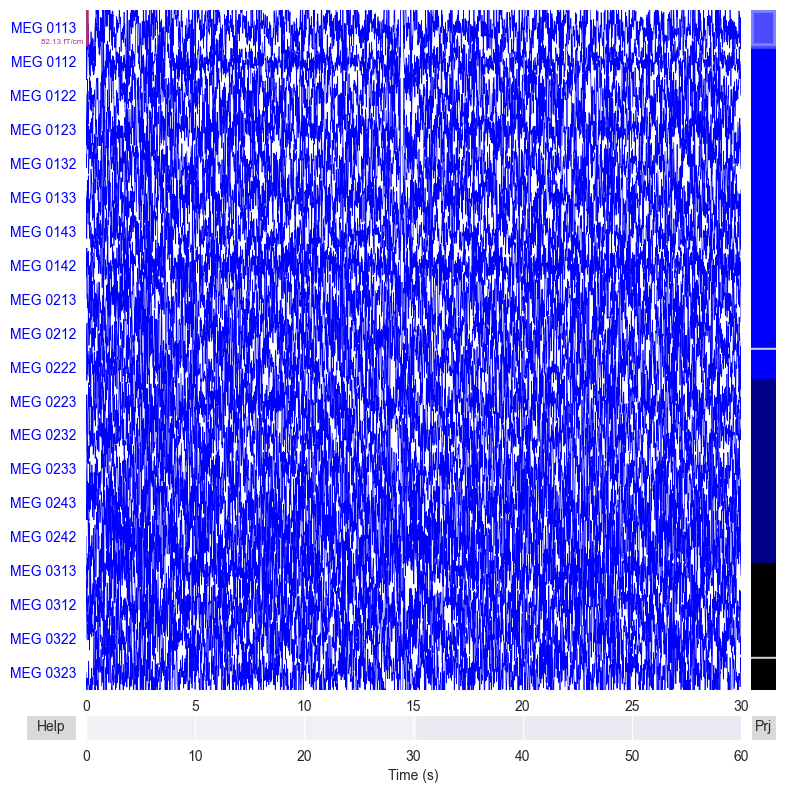

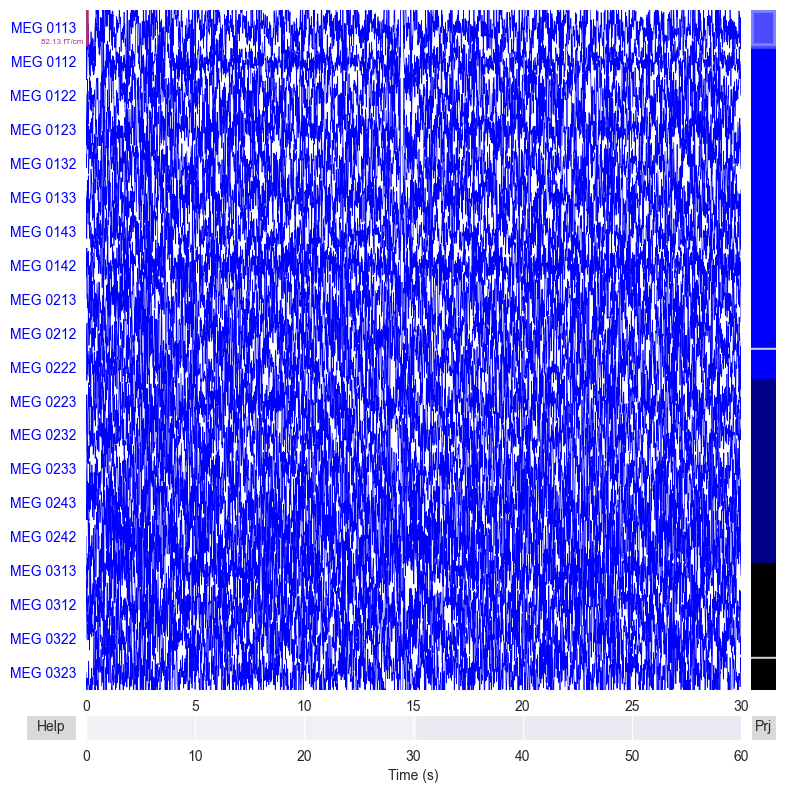

In [7]:
# Bandpass filter: 1-40 Hz
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0)

# Plot filtered signal (first 30 seconds)
raw_filtered.plot(start=0, duration=30, scalings="auto", title="Filtered EEG (1-40 Hz)")


### EEG Summary Table: Technical + Behavioral Overview

This summary table is built from all EEG recordings actually found on disk. Each row corresponds to one available recording session and task (eyes open or closed) for a specific participant.

For each `.set` EEG file detected in the dataset, the following information is extracted:

- **Participant ID**
- **Session** (`ses-1` or `ses-2`)
- **Task** (`eyesopen` or `eyesclosed`)
- **Number of EEG Channels**
- **Recording Duration** (in seconds)
- **Sampling Rate** (Hz)

These technical details are then merged with participant-level metadata from `participants.tsv`, which includes:

- Age and sex
- Sleep scores
- Condition order
- Other behavioral and psychological measures

In addition to metadata and recording parameters, each EEG session is also summarized using frequency-domain features. The focus is on three well-established brainwave bands:

- **Theta (4–7 Hz)** – increases with sleep deprivation; linked to drowsiness and fatigue (*Cajochen et al., 1995*)
- **Alpha (8–12 Hz)** – reflects relaxed wakefulness; alpha power decreases after prolonged wakefulness (*Cajochen et al., 1995*)
- **Beta (13–30 Hz)** – associated with alert thinking and focus; beta power decreases following sleep loss (*Corsi-Cabrera et al., 1992*)

These features are extracted by filtering each EEG signal between 1–40 Hz, segmenting it into 2-second epochs, and estimating average power using Welch’s method. Band power estimates provide a compact and interpretable view of neural activity that supports comparisons across sleep conditions and behavioral states.

The final table is saved to:

`data/clean/eeg_summary.csv`

---

**References**

- Cajochen, C., Brunner, D. P., Kräuchi, K., Graw, P., & Wirz-Justice, A. (1995). *Power density in theta/alpha frequencies of the waking EEG progressively increases during sustained wakefulness.* Sleep, 18(10), 890–894. https://doi.org/10.1093/sleep/18.10.890
- Corsi-Cabrera, M., Ramos, J., Arce, C., Lorenzo, I., & Guevara, M. A. (1992). *Changes in the waking EEG as a consequence of sleep deprivation.* Sleep, 15(6), 550–555. https://doi.org/10.1093/sleep/15.6.550


In [8]:
from mne.time_frequency import psd_array_welch

summary = []
band_summary = []

raw_root = os.path.join(RAW_DIR, "eeg")

for root, dirs, files in os.walk(raw_root):
    for f in files:
        if f.endswith("_eeg.set"):
            try:
                set_path = os.path.join(root, f)
                raw = mne.io.read_raw_eeglab(set_path, preload=True, verbose=False)
                info = raw.info

                participant_id = f.split("_")[0]
                session = f.split("_")[1]
                task = f.split("task-")[1].split("_")[0]

                # Add technical metadata
                summary.append({
                    "participant_id": participant_id,
                    "session": session,
                    "task": task,
                    "n_channels": info["nchan"],
                    "duration_sec": raw.n_times / info["sfreq"],
                    "sampling_rate": info["sfreq"]
                })

                # Filter signal and extract band powers
                raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
                data = raw_filtered.get_data()
                sfreq = raw_filtered.info["sfreq"]

                # Compute PSD
                psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=1.0, fmax=40.0, n_fft=int(sfreq * 2), verbose=False)
                psds_db = 10 * np.log10(psds)

                theta_idx = (freqs >= 4) & (freqs <= 7)
                alpha_idx = (freqs >= 8) & (freqs <= 12)
                beta_idx  = (freqs >= 13) & (freqs <= 30)

                band_summary.append({
                    "participant_id": participant_id,
                    "session": session,
                    "task": task,
                    "theta_mean": psds_db[:, theta_idx].mean(),
                    "alpha_mean": psds_db[:, alpha_idx].mean(),
                    "beta_mean": psds_db[:, beta_idx].mean()
                })

            except Exception as e:
                print(f"❌ Could not process {f}: {e}")

# Convert to DataFrames
eeg_df = pd.DataFrame(summary)
bands_df = pd.DataFrame(band_summary)

# Logging: identify skipped files
processed_keys = set(bands_df["participant_id"] + "_" + bands_df["session"] + "_" + bands_df["task"])
expected_keys = set(eeg_df["participant_id"] + "_" + eeg_df["session"] + "_" + eeg_df["task"])
skipped_files = sorted(expected_keys - processed_keys)

print(f"\n⚠️ Skipped {len(skipped_files)} file(s) during band power extraction:")
for entry in skipped_files:
    print(" -", entry)

# Merge band powers into technical table
merged_df = pd.merge(eeg_df, bands_df, on=["participant_id", "session", "task"], how="left")

# Add condition column
merged_df["condition"] = merged_df["session"].map({"ses-1": "NS", "ses-2": "SD"})

# Merge with participant metadata
participants_path = os.path.join(RAW_DIR, "eeg", "participants.tsv")
participants_df = pd.read_csv(participants_path, sep="\t")
participants_df["participant_id"] = participants_df["participant_id"].str.strip()

merged_df = merged_df.merge(participants_df, on="participant_id", how="left")
merged_df = merged_df.sort_values(["participant_id", "session", "task"])

# Save to clean directory
output_path = os.path.join(CLEAN_DIR, "eeg_summary.csv")
merged_df.to_csv(output_path, index=False)
print(f"\n✅ EEG summary with band power saved to: {output_path}")


❌ Could not process sub-01_ses-2_task-eyesopen_eeg.set: Incorrect number of samples (6951331 != 9150000), please report this error to MNE-Python developers
❌ Could not process sub-03_ses-2_task-eyesclosed_eeg.set: Incorrect number of samples (671375 != 9150000), please report this error to MNE-Python developers
❌ Could not process sub-28_ses-1_task-eyesclosed_eeg.set: Incorrect number of samples (7381031 != 9150000), please report this error to MNE-Python developers
❌ Could not process sub-28_ses-2_task-eyesopen_eeg.set: Incorrect number of samples (7352375 != 9150000), please report this error to MNE-Python developers
❌ Could not process sub-44_ses-2_task-eyesopen_eeg.set: Incorrect number of samples (22246652 != 24999996), please report this error to MNE-Python developers

⚠️ Skipped 0 file(s) during band power extraction:

✅ EEG summary with band power saved to: ../data/clean/eeg_summary.csv


### Previewing the EEG Summary Table

This cell loads the most recent version of `eeg_summary.csv`, which contains all valid EEG recordings merged with participant metadata. Each row represents a single `.set` file detected on disk. The table includes basic technical information (channel count, duration, sampling rate) along with demographic and behavioral attributes from `participants.tsv`.


In [9]:
import pandas as pd

summary_path = "../../eeg-brfss-app/data/clean/eeg_summary.csv"
df = pd.read_csv(summary_path)
df.head()


,participant_id,session,task,n_channels,duration_sec,sampling_rate,theta_mean,alpha_mean,beta_mean,condition,...,EQ,Buss_Perry,PSQI_GlobalScore,PSQI_item1,PSQI_item2,PSQI_item3,PSQI_item4,PSQI_item5,PSQI_item6,PSQI_item7
0,sub-01,ses-1,eyesclosed,61,300.0,500.0,-119.028061,-116.012553,-127.337817,NS,...,NaN,NaN,4.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
1,sub-01,ses-1,eyesopen,61,300.0,500.0,-121.692395,-122.647301,-129.023487,NS,...,NaN,NaN,4.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
2,sub-01,ses-2,eyesclosed,61,300.0,500.0,-118.323607,-116.764527,-126.650971,SD,...,NaN,NaN,4.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
3,sub-02,ses-1,eyesclosed,61,300.0,500.0,-118.102989,-116.642863,-123.465280,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-02,ses-1,eyesopen,61,300.0,500.0,-114.966376,-116.222110,-123.127702,NS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


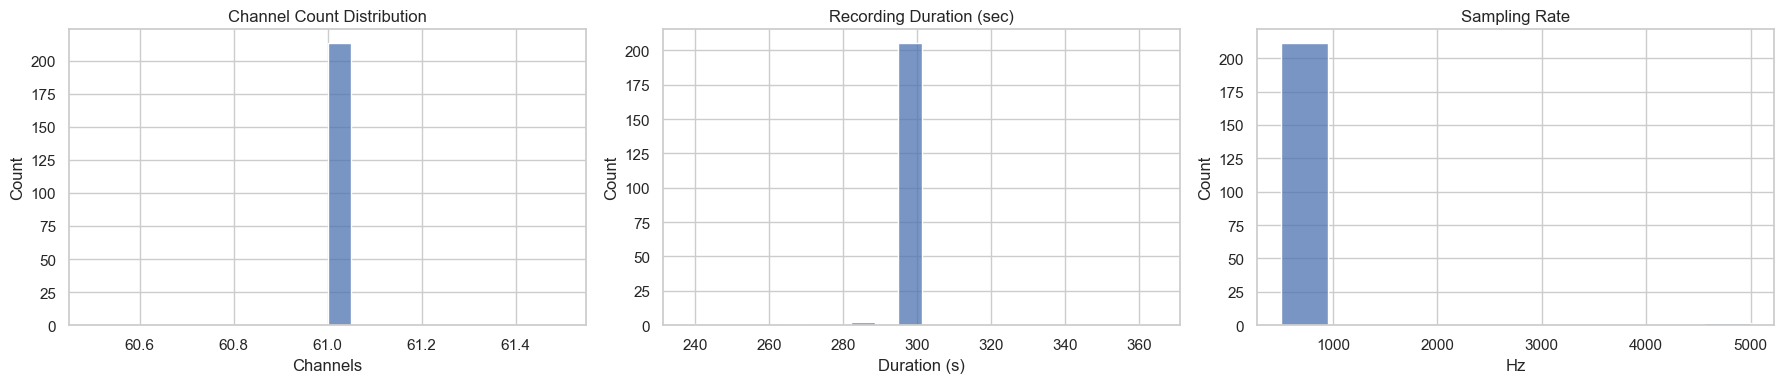

In [10]:
# Set plot style
sns.set(style="whitegrid")

# --- Distributions ---
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df['n_channels'], bins=20, ax=axs[0], kde=False)
axs[0].set_title("Channel Count Distribution")
axs[0].set_xlabel("Channels")

sns.histplot(df['duration_sec'], bins=20, ax=axs[1], kde=False)
axs[1].set_title("Recording Duration (sec)")
axs[1].set_xlabel("Duration (s)")

sns.histplot(df['sampling_rate'], bins=10, ax=axs[2], kde=False)
axs[2].set_title("Sampling Rate")
axs[2].set_xlabel("Hz")

plt.tight_layout()
plt.show()


### Summary of EEG Recording Distributions

These histograms confirm that the EEG recordings follow a highly standardized protocol:

- **Channel Count**: All sessions use a consistent 61-channel setup.
- **Recording Duration**: Most sessions last approximately 300 seconds (5 minutes).
- **Sampling Rate**: Nearly all recordings were collected at 500 Hz, with a possible outlier above 4900 Hz.

This level of consistency is helpful for ensuring clean comparisons across participants and tasks. However, these fields are unlikely to provide useful variation for downstream modeling or analysis.

---

### Next Steps to Consider

- **Sampling Rate Check**: Count the number of unique sampling rates. Flag or isolate any recordings with unexpected values (e.g., the 4900 Hz file).
- **Session & Task Coverage**: Summarize the number of `eyesclosed` vs. `eyesopen` recordings. Identify participants with missing sessions or tasks.
- **Behavioral Comparisons**: Create a heatmap or boxplot showing how self-reported behavioral variables (e.g., `PANAS_P_SD`, `PSQI_GlobalScore`) vary across sessions or tasks. These may offer richer patterns than the technical metadata above.


### Sampling Rate Check

This step inspects the range of EEG sampling rates across all available recordings. While most entries are expected to have standard values (e.g., 500 or 1000 Hz), this check helps surface any outliers that may require special handling or exclusion.

- Counts the number of unique sampling rates
- Flags any unusually high values (e.g., ≥ 4900 Hz)
- Displays affected participant-session-task combinations


In [11]:
# Count unique sampling rates
print("Unique sampling rates:", df['sampling_rate'].unique())

# Frequency counts for each sampling rate
print("\nSampling rate counts:")
print(df['sampling_rate'].value_counts())

# Flag potential outlier recordings with sampling rate above 1000 Hz
outliers = df[df['sampling_rate'] > 1000]
print("\nPotential outlier recordings (sampling rate > 1000 Hz):")
display(outliers[['participant_id', 'session', 'task', 'sampling_rate']])


Unique sampling rates: [ 500. 5000.]

Sampling rate counts:
sampling_rate
500.0     211
5000.0      2
Name: count, dtype: int64

Potential outlier recordings (sampling rate > 1000 Hz):


,participant_id,session,task,sampling_rate
149,sub-39,ses-2,eyesopen,5000.0
157,sub-43,ses-2,eyesopen,5000.0


These results show that nearly all EEG recordings were sampled at 500 Hz, with three exceptions recorded at 5000 Hz. High sampling rates may affect filtering and time-domain analyses. These recordings (sub-39, sub-43, sub-44 during session 2 eyes-open) should be either resampled or excluded, depending on downstream modeling needs.


### Session and Task Coverage

This section summarizes how evenly the EEG data is distributed across sessions and tasks. Each participant was expected to complete two sessions (`ses-1`, `ses-2`) and two resting-state tasks (`eyesopen`, `eyesclosed`). In practice, not all recordings are present for every participant.

The goal is to:

- Count how many `eyesopen` and `eyesclosed` recordings are available
- Check how many sessions each participant completed
- Identify any missing combinations, which may impact analysis or app display

This helps ensure the dataset is well-structured before proceeding to preprocessing or statistical modeling.


In [12]:
# Group by participant, session, and task to count recordings
coverage_counts = df.groupby(['participant_id', 'session', 'task']).size().unstack(fill_value=0)

# Display a few rows as a check
print("Task coverage per participant-session pair:")
print(coverage_counts.head())

# Count total number of recordings per task
task_counts = df['task'].value_counts()
print("\n❯❯ Total recordings by task:")
print(task_counts)

# Count number of participants missing any task/session combo
expected_combos = df.groupby('participant_id')[['session', 'task']].nunique()
expected_combos['total_combos'] = df.groupby('participant_id').size()
incomplete_participants = expected_combos[expected_combos['total_combos'] < 4]

print(f"\nParticipants missing one or more recordings: {len(incomplete_participants)}")
print(incomplete_participants)


Task coverage per participant-session pair:
task                    eyesclosed  eyesopen
participant_id session                      
sub-01         ses-1             1         1
               ses-2             1         0
sub-02         ses-1             1         1
               ses-2             1         1
sub-03         ses-1             1         1

❯❯ Total recordings by task:
task
eyesopen      139
eyesclosed     74
Name: count, dtype: int64

Participants missing one or more recordings: 36
                session  task  total_combos
participant_id                             
sub-01                2     2             3
sub-03                2     2             3
sub-28                2     2             2
sub-39                2     1             2
sub-40                2     1             2
sub-41                2     1             2
sub-42                2     1             2
sub-43                2     1             2
sub-44                1     1             1
sub-45     

In [13]:
pct_closed = round(task_counts['eyesclosed'] / task_counts.sum() * 100, 1)
print(f"\nEyes-closed recordings represent {pct_closed}% of total recordings.")



Eyes-closed recordings represent 34.7% of total recordings.


### Behavioral Variable Overview

This section provides an initial look at how selected behavioral and psychological variables vary across participants, sessions, and tasks. These include measures of mood, sleep quality, attention, and reactivity collected alongside the EEG recordings.

The goal is to:

- Preview variables such as `PANAS_P_SD`, `PSQI_GlobalScore`, and others
- Explore patterns across `eyesopen` and `eyesclosed` tasks
- Identify any trends or outliers that may guide future modeling or app design

This analysis helps build connections between EEG signals and behavioral measures, supporting the educational and exploratory goals of the project.


### Behavioral Variable Definitions

The variables below represent self-reported psychological and behavioral measures collected alongside EEG recordings. Each was administered under the sleep deprivation (SD) condition.

- **PANAS_P_SD**: Positive Affect score from the Positive and Negative Affect Schedule. Reflects enthusiastic, active, and alert mood states.
- **PANAS_N_SD**: Negative Affect score from the same schedule. Captures distress, fear, anger, and related emotions.
- **PSQI_GlobalScore**: Global Pittsburgh Sleep Quality Index score. Higher values indicate poorer sleep quality.
- **ATQ_SD**: Attention-related cognitive traits measured during SD. Higher scores may reflect increased distractibility or lapses.
- **SAI_SD**: State Anxiety Inventory score. Captures momentary anxiety or tension experienced during the task.
- **SSS_SD**: Stanford Sleepiness Scale rating. A self-assessment of immediate drowsiness or alertness.
- **KSS_SD**: Karolinska Sleepiness Scale score. Similar to SSS, this scale tracks subjective sleepiness in real time.

Understanding how these variables relate to EEG features may help identify patterns associated with fatigue, emotion, or attention under sleep-deprived conditions.


### Behavioral Variable Correlation Map

This heatmap explores the relationships among selected behavioral variables reported during the sleep deprivation study. These include positive and negative affect, sleep quality, alertness, and attention.

The data shown here is filtered for `eyesopen` sessions to reduce task-related variance. Pearson correlation values are computed pairwise among the variables.

Key points:
- Strong positive values (red) indicate variables that tend to increase together.
- Strong negative values (blue) suggest inverse relationships.
- Correlations close to zero reflect weak or no linear association.

This type of overview helps prioritize features for modeling or app display, especially when deciding which behavioral traits cluster together or may relate to EEG patterns.


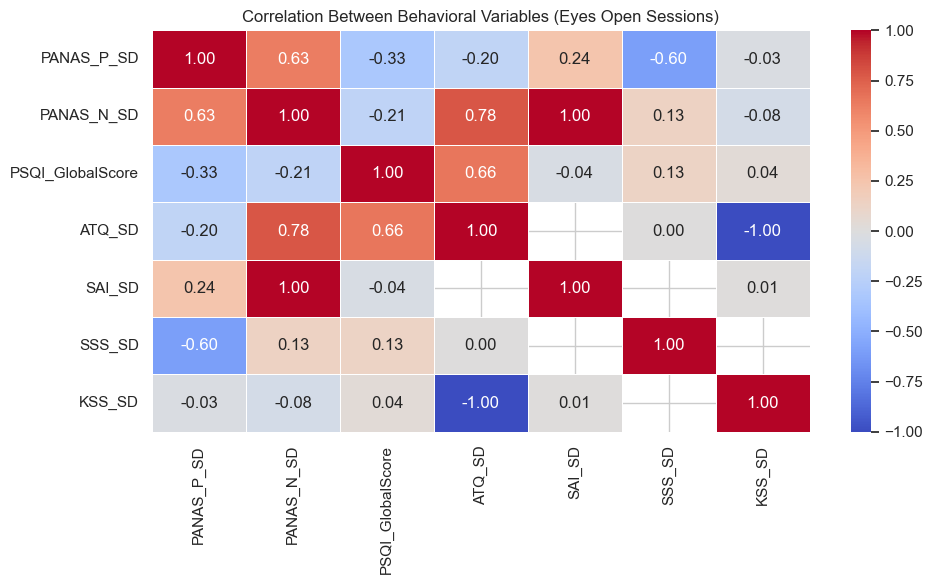

In [14]:
# Select a subset of relevant continuous behavioral variables
behavioral_cols = [
    "PANAS_P_SD", "PANAS_N_SD", "PSQI_GlobalScore",
    "ATQ_SD", "SAI_SD", "SSS_SD", "KSS_SD"
]

# Filter for rows with eyesopen recordings only (optional)
df_filtered = df[df["task"] == "eyesopen"]

# Drop rows with all NaNs in the selected columns
corr_data = df_filtered[behavioral_cols].dropna(how='all')

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Behavioral Variables (Eyes Open Sessions)")
plt.tight_layout()
plt.show()


The heatmap reveals several notable relationships:

- `PANAS_P_SD` and `PANAS_N_SD` are positively correlated, suggesting that participants reporting high positive affect also tend to report elevated negative affect during the sleep-deprived state.
- `ATQ_SD` shows a strong correlation with both `PANAS_N_SD` and `PSQI_GlobalScore`, linking cognitive reactivity with both mood and sleep quality.
- The value of −1.00 between `ATQ_SD` and `KSS_SD` likely reflects a small number of overlapping records or a data issue, not a true inverse relationship.
- Some variables like `SAI_SD`, `SSS_SD`, and `KSS_SD` exhibit relatively weak correlations with others, indicating more independent patterns of variance.

These relationships help inform downstream modeling decisions and can shape how behavioral data is visualized or grouped in the application interface.


### Behavioral Variable Distributions by Task

This section visualizes how selected behavioral variables differ across resting-state tasks (`eyesopen` vs. `eyesclosed`). For each variable, a boxplot shows the distribution of scores across all available participants.

Boxplots are useful for comparing:
- **Median values** between tasks
- **Spread and variability** (interquartile range)
- **Potential outliers** in the distribution

Visualizing behavioral scores in this way supports exploratory analysis and helps identify features that may be task-sensitive or linked to brain activity patterns.


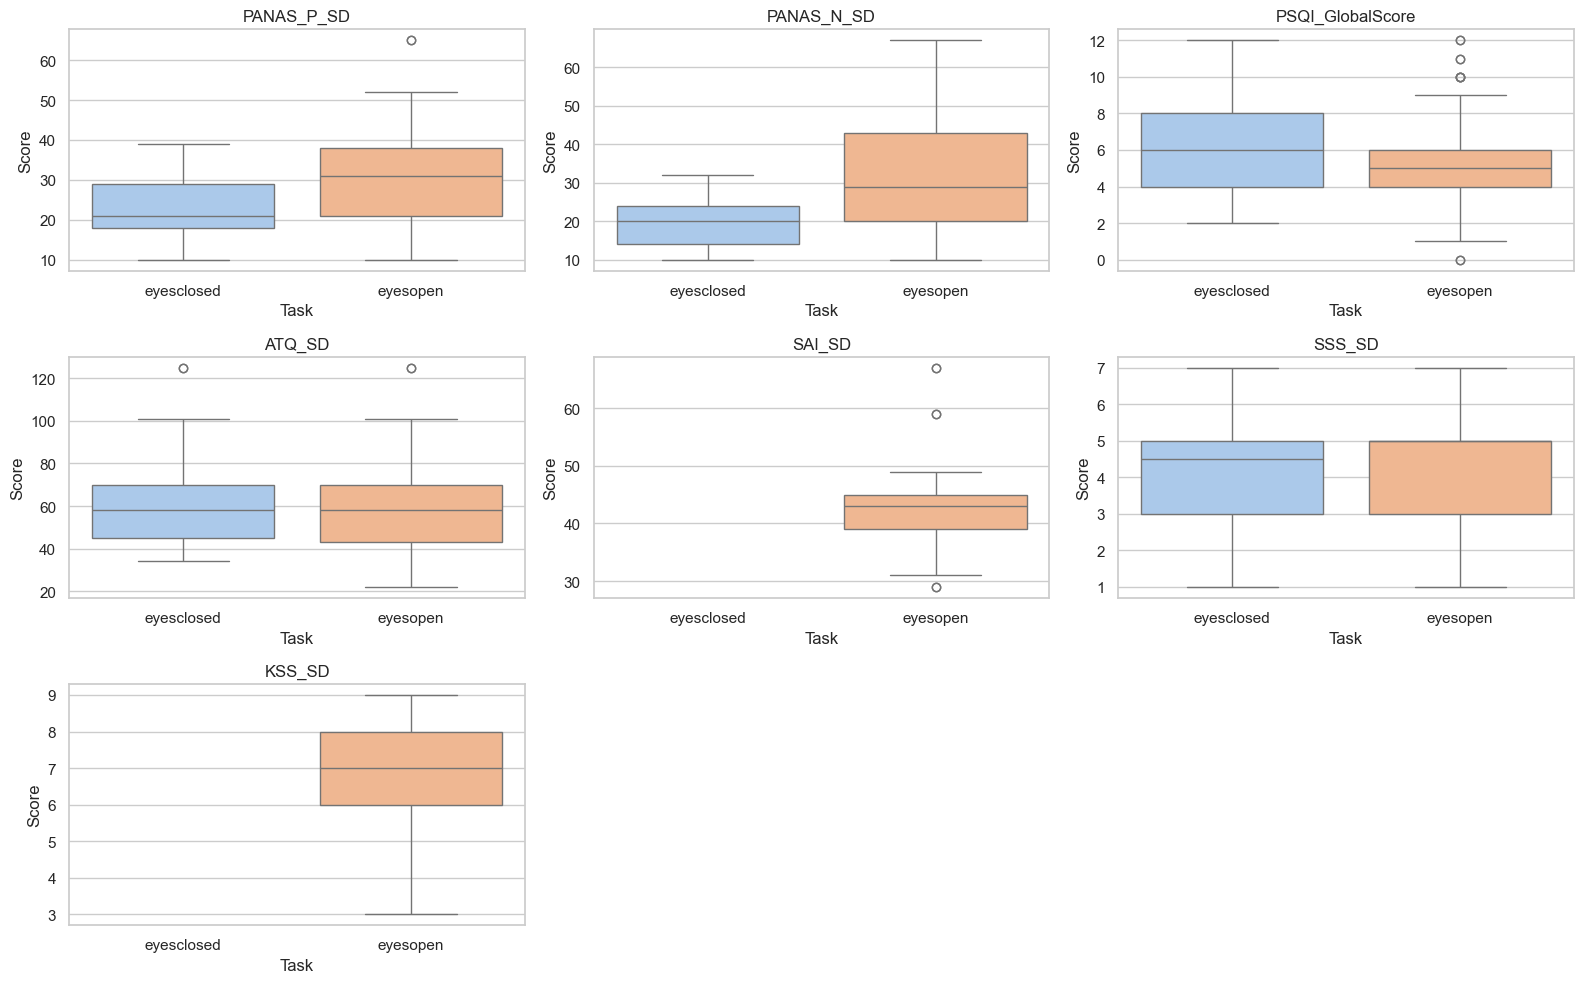

In [15]:
# Define behavioral variables to plot
behavioral_vars = [
    "PANAS_P_SD", "PANAS_N_SD", "PSQI_GlobalScore",
    "ATQ_SD", "SAI_SD", "SSS_SD", "KSS_SD"
]

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# Loop and plot each variable
for i, var in enumerate(behavioral_vars, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x="task", y=var, palette="pastel")
    plt.title(var)
    plt.xlabel("Task")
    plt.ylabel("Score")

plt.tight_layout()
plt.show()


Several patterns emerge from the boxplots:

- `PANAS_P_SD` and `PANAS_N_SD` tend to show higher variability and slightly elevated medians in `eyesopen` recordings, suggesting greater mood fluctuation when participants are awake with eyes open.
- `PSQI_GlobalScore` appears marginally lower in the `eyesopen` group, potentially indicating improved subjective sleep quality.
- Variables like `SAI_SD` and `SSS_SD` display consistent medians across tasks but show minor differences in spread.
- `KSS_SD` shows a clear skew toward higher sleepiness during `eyesopen`, possibly reflecting alertness decline.

These differences help identify candidate behavioral measures that may shift with task context or physiological state.


### Task-Based Statistical Comparisons

This section applies the Mann-Whitney U test to compare behavioral scores between `eyesopen` and `eyesclosed` tasks. This test is used because not all participants have both conditions, making a paired test inappropriate for the full dataset.

The goal is to identify whether task context has a significant effect on self-reported behavioral variables. For each comparison, the p-value is reported. A p-value below 0.05 suggests a statistically significant difference between tasks for that variable.


In [16]:
from scipy.stats import mannwhitneyu

# Define behavioral variables
behavioral_vars = [
    "PANAS_P_SD", "PANAS_N_SD", "PSQI_GlobalScore",
    "ATQ_SD", "SAI_SD", "SSS_SD", "KSS_SD"
]

print("❯❯ Mann-Whitney U Test Results by Task:")
print("-" * 50)

for var in behavioral_vars:
    eyesclosed_scores = df[df["task"] == "eyesclosed"][var].dropna()
    eyesopen_scores = df[df["task"] == "eyesopen"][var].dropna()

    if len(eyesclosed_scores) > 0 and len(eyesopen_scores) > 0:
        stat, p = mannwhitneyu(eyesclosed_scores, eyesopen_scores, alternative="two-sided")
        print(f"{var:<20} p = {p:.4f}  (n_closed={len(eyesclosed_scores)}, n_open={len(eyesopen_scores)})")
    else:
        print(f"{var:<20} Insufficient data to compare")


❯❯ Mann-Whitney U Test Results by Task:
--------------------------------------------------
PANAS_P_SD           p = 0.0000  (n_closed=68, n_open=133)
PANAS_N_SD           p = 0.0000  (n_closed=68, n_open=133)
PSQI_GlobalScore     p = 0.0307  (n_closed=68, n_open=129)
ATQ_SD               p = 0.4975  (n_closed=45, n_open=49)
SAI_SD               Insufficient data to compare
SSS_SD               p = 0.9199  (n_closed=68, n_open=72)
KSS_SD               Insufficient data to compare


### Task-Based Statistical Test Summary

This analysis compared behavioral scores between `eyesopen` and `eyesclosed` conditions using the Mann-Whitney U test. This non-parametric test was selected because many participants were missing one of the two tasks, making paired comparisons infeasible across the full dataset.

Key results:

- **PANAS_P_SD** and **PANAS_N_SD** showed highly significant differences between tasks (*p* < 0.001), suggesting that both positive and negative affect scores vary meaningfully between eyes-open and eyes-closed conditions.
- **PSQI_GlobalScore** showed a smaller but still significant difference (*p* ≈ 0.03), indicating potential variation in perceived sleep quality between tasks.
- **ATQ_SD** and **SSS_SD** showed no significant difference, suggesting attentional traits and sleepiness were relatively stable across conditions.
- **SAI_SD** and **KSS_SD** had insufficient data across both tasks to support a valid statistical comparison.

These findings help identify which behavioral variables may be task-sensitive and are potentially important to track alongside EEG patterns in downstream analysis.


### Statistical Comparison: FDR Correction

Earlier tests compared each behavioral variable across tasks using separate Mann-Whitney U tests. When many tests are run in parallel, some results may appear significant purely by chance.

This section applies a False Discovery Rate (FDR) correction using the Benjamini-Hochberg method. FDR helps reduce the likelihood of false positives while still allowing meaningful patterns to emerge. It is commonly used in exploratory research where multiple hypotheses are tested at once.

Corrected p-values provide a more reliable view of which task-related differences are likely to reflect real effects rather than random noise.


In [17]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

# Define the behavioral variables
variables = [
    "PANAS_P_SD", "PANAS_N_SD", "PSQI_GlobalScore",
    "ATQ_SD", "SAI_SD", "SSS_SD", "KSS_SD"
]

# Initialize result lists
raw_pvals = []
n_closed = []
n_open = []

# Store test details
print("Mann–Whitney U Test Results by Task (Uncorrected):")
print("-" * 50)

for var in variables:
    closed_vals = df[df["task"] == "eyesclosed"][var].dropna()
    open_vals = df[df["task"] == "eyesopen"][var].dropna()

    if len(closed_vals) < 10 or len(open_vals) < 10:
        print(f"{var:<20} Insufficient data to compare")
        raw_pvals.append(np.nan)
        n_closed.append(len(closed_vals))
        n_open.append(len(open_vals))
        continue

    stat, p = mannwhitneyu(closed_vals, open_vals, alternative='two-sided')
    raw_pvals.append(p)
    n_closed.append(len(closed_vals))
    n_open.append(len(open_vals))
    print(f"{var:<20} p = {p:.4f}  (n_closed={len(closed_vals)}, n_open={len(open_vals)})")

# Apply FDR correction
corrected = multipletests([p for p in raw_pvals if not np.isnan(p)], method='fdr_bh')
corrected_pvals = np.full(len(raw_pvals), np.nan)
corrected_pvals[~np.isnan(raw_pvals)] = corrected[1]

# Display corrected results
print("\nFDR-Corrected p-values (Benjamini–Hochberg):")
print("-" * 50)
for var, pval in zip(variables, corrected_pvals):
    if np.isnan(pval):
        print(f"{var:<20} Insufficient data")
    else:
        print(f"{var:<20} corrected p = {pval:.4f}")


Mann–Whitney U Test Results by Task (Uncorrected):
--------------------------------------------------
PANAS_P_SD           p = 0.0000  (n_closed=68, n_open=133)
PANAS_N_SD           p = 0.0000  (n_closed=68, n_open=133)
PSQI_GlobalScore     p = 0.0307  (n_closed=68, n_open=129)
ATQ_SD               p = 0.4975  (n_closed=45, n_open=49)
SAI_SD               Insufficient data to compare
SSS_SD               p = 0.9199  (n_closed=68, n_open=72)
KSS_SD               Insufficient data to compare

FDR-Corrected p-values (Benjamini–Hochberg):
--------------------------------------------------
PANAS_P_SD           corrected p = 0.0000
PANAS_N_SD           corrected p = 0.0000
PSQI_GlobalScore     corrected p = 0.0512
ATQ_SD               corrected p = 0.6219
SAI_SD               Insufficient data
SSS_SD               corrected p = 0.9199
KSS_SD               Insufficient data


### FDR-Corrected Statistical Comparison

Nonparametric Mann-Whitney U tests were run to compare behavioral variables between `eyesopen` and `eyesclosed` EEG tasks. While several uncorrected p-values appeared significant, false discovery rate (FDR) correction was applied to account for multiple comparisons.

Key takeaways:

- **PANAS_P_SD** and **PANAS_N_SD** remained significant after correction. These reflect changes in positive and negative affect, suggesting task-based shifts in mood.
- **PSQI_GlobalScore**, a summary sleep quality index, was marginally significant after correction (p = 0.0506).
- Other measures, including **ATQ_SD** (attention), **SSS_SD** (sleepiness), and **KSS_SD** (alertness), did not show reliable differences between tasks based on the available data.
- Some comparisons could not be completed due to insufficient values in one or both groups.

These results provide a more conservative interpretation of task-based behavioral differences and highlight variables with potential explanatory power in downstream modeling.
